# 1 Finding Co-located EMIT and NEON AOP Data

**Summary**  

The Earth surface Mineral dust source InvesTigation (EMIT) instrument is located on the International Space Station (ISS) and has collected data over a large area of the Continental US. The National Ecological Observatory Network (NEON) Airborne Observation Platform (AOP) collects aerial remote sensing data, including hyperspectral reflectance data over sites across the United States and Puerto Rico. In this notebook we will show how to utilize the [`earthaccess` Python library](https://github.com/nsidc/earthaccess) to find spatially overlapping EMIT and NEON reflectance data at NEON's [Niwot Ridge](https://www.neonscience.org/field-sites/niwo) site (NIWO) in the Rocky Mountains of Colorado.

<div>
<img src="./neon_notebook_figs/NEON_NIWO_EMIT_Co-located_Data.PNG" width="750"/>
</div>

**Background**

The **EMIT** instrument is an imaging spectrometer that measures light in visible (V) to short-wave (SWIR) infrared wavelengths; this is also referred to as a VSWIR sensor. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. In addition, the EMIT instrument can be used in other applications, such as mapping of greenhouse gases, snow properties, and water resources.

More details about EMIT and its associated products can be found on the [EMIT website](https://earth.jpl.nasa.gov/emit/) and [EMIT product pages](https://lpdaac.usgs.gov/product_search/?query=EMIT&status=Operational&view=cards&sort=title) hosted by the LP DAAC.

The **NEON Imaging Spectrometer (NIS)** is an airborne [imaging spectrometer](https://www.neonscience.org/data-collection/imaging-spectrometer) built by JPL (AVIRIS-NG) and operated by the National Ecological Observatory Network's (NEON) Airborne Observation Platform (AOP). NEON's hyperspectral sensors collect measurements of sunlight reflected from the Earth's surface in 426 narrow (~5 nm) spectral channels spanning wavelengths between ~ 380 - 2500 nm. NEON's remote sensing data is intended to map and answer questions about a landscape, with ecological applications including identifying and classifying plant species and communities, mapping vegetation health, detecting disease or invasive species, and mapping droughts, wildfires, or other natural disturbances and their impacts. 

NEON surveys sites spanning the continental US, during peak phenological greenness, capturing each site 3 out of every 5 years, for most terrestrial sites. AOP's [Flight Schedules and Coverage](https://www.neonscience.org/data-collection/flight-schedules-coverage) provide's more information about the current and past schedules.

More detailed information about NEON's airborne sampling design can be found in the paper: [Spanning scales: The airborne spatial and temporal sampling design of the National Ecological Observatory Network](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.13942).

**Requirements**  
 - [NASA Earthdata Account](https://urs.earthdata.nasa.gov/home)   
 - *No Python setup requirements if connected to the workshop cloud instance!*  
 - **Local Only** Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder to set up a local compatible Python environment

 - NEON User Account and API Token (optional, but recommended), see [NEON API Tokens Tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial)

**Download the NEON Flight Boundary Shapefile:** <a href="https://www.neonscience.org/sites/default/files/AOP_flightBoxes_0.zip" class="link--button link--arrow">AOP_flightBoxes.zip</a>

**Learning Objectives**  
- Use functions provided in an external Python module to find and download available NEON airborne reflectance data.
- Use `earthaccess` to find EMIT data that overlaps with a NEON site.
- How to export a list of files and download them programmatically.  

**Tutorial Outline**  

1. Setup - NEON and NASA data accounts
2. Visualize and download NEON data for a single site
3. Find Co-located EMIT collections and download

## 1. Setup

Import the required Python libraries. You can install the Python `neonutilities` package using `!pip install neonutilities`. This package will allow you to find available NEON data and download NEON Airborne Observation Platform (AOP) data, using the NEON API.

In [1]:
# Import required libraries
import os, sys
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math
import requests
import neonutilities as nu
from zipfile import ZipFile
from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

### 1.2 NEON Token

Please see [Using an API Token when Accessing NEON Data with neonUtilities](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial) for more details on setting up a NEON token. Tokens are not required as of Winter 2025, but starting in mid-2026 tokens will be required for downloadng NEON data.

Once you've set up your account and generated a token, you can use the `python-dotenv` package to store the token and access it in Python as follows:

```
!pip install python-dotenv
```

```
dotenv.set_key(dotenv_path=".env",
key_to_set="NEON_TOKEN",
value_to_set="YOUR TOKEN HERE
```

```
dotenv.load_dotenv()
```")

### 1.3 NASA Earthdata Login Credentials

To download or stream NASA data you will need an Earthdata account, you can create one [here](https://urs.earthdata.nasa.gov/home). We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn't exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

## 2. Visualize and download NEON data for a single site

NEON data products are hosted on the NEON Data Portal, and can be accessed via an API. We will import a Python package `neonutilities` which includes some functions that interact with the NEON data API to see what data are available (in what year and months data were collected), and download data.

The EMIT products are hosted by the Land Processes Distributed Active Archive Center (LP DAAC). In this example we will use the cloud-hosted `EMIT_L2A_RFL` products available from the LP DAAC to find data. 

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists of granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (ex: Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection). We can search using attributes such as collection, acquisition time, and spatial footprint. This process can also be used with other EMIT products, other collections, or different data providers, as well as across multiple catalogs with some modification. 

### 2.1 Define NEON Region of Interest (ROI)

For this example, our spatial region of interest (ROI) will be the NEON site [Niwot Ridge (NIWO)](https://www.neonscience.org/field-sites/niwo) in the Rocky Mountains, Colorado.

We will create a rectangular ROI surrounding the NIWO flight box. We will search for co-located EMIT data using a polygon rather than a standard bounding box in `earthaccess`. To search for intersections with a polygon using earthaccess, we need to format our ROI as a counterclockwise list of coordinate pairs. 

Download, Unzip, and Open the shape file (.shp) containing the AOP flight box boundaries, which can be downloaded from [NEON Spatial Data and Maps](https://www.neonscience.org/data-samples/data/spatial-data-maps). Read this into a `geodataframe`, explore the contents, and check the coordinate reference system (CRS) of the data.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [3]:
# Download and Unzip the NEON Flight Boundary Shapefile
neon_boundary_url = "https://www.neonscience.org/sites/default/files/AOP_flightBoxes_0.zip"
# Use download_url function to save the file to a directory
os.makedirs('./data', exist_ok=True)
download_url(neon_boundary_url,'./data')
# Unzip the file
with ZipFile(f"./data/{neon_boundary_url.split('/')[-1]}", 'r') as zip_ref:
    zip_ref.extractall('./data')

In [4]:
aop_flightboxes = gpd.read_file("./data/AOP_flightBoxes/AOP_flightboxesAllSites.shp")
aop_flightboxes.head()

domain domainName                                 siteName siteID  siteType  \
0    D01  Northeast        Bartlett Experimental Forest NEON   BART  Gradient   
1    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
2    D01  Northeast  Harvard Forest & Quabbin Watershed NEON   HARV      Core   
3    D01  Northeast                     Lower Hop Brook NEON   HOPB      Core   
4    D19      Taiga                               Healy NEON   HEAL  Gradient   

    sampleType  priority  version         flightbxID  \
0  Terrestrial         1        1  D01_BART_R1_P1_v1   
1  Terrestrial         1        1  D01_HARV_C1_P1_v1   
2  Terrestrial         3        1  D01_HARV_C1_P3_v1   
3      Aquatic         2        1  D01_HOPB_C1_P2_v1   
4  Terrestrial         1        1  D19_HEAL_R3_P1_v1   

                                            geometry  
0  POLYGON ((-71.33426 43.99197, -71.33423 44.081...  
1  POLYGON ((-72.14819 42.57510, -72.14776 42.383...  
2  POLYGON ((-72.10812 42.43653, -72.14788 42.436...  
3  POLYGON ((-72.36635 42.46399, -72.36635 42.514...  
4  POLYGON ((-149.31505 63.82981, -149.31505 63.9...

In [5]:
aop_flightboxes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS is **EPSG:4326** (WGS84), which is also the CRS we want the data in to submit for our search of EMIT data.

Next, let's examine the AOP flightboxes polygons further. For this exercise, we'll first look at Niwot Ridge site in Colorado.

In [6]:
aop_flightboxes[aop_flightboxes.siteID == 'NIWO']

domain                           domainName          siteName siteID  \
49    D13  Southern Rockies & Colorado Plateau  Niwot Ridge NEON   NIWO   

   siteType   sampleType  priority  version         flightbxID  \
49     Core  Terrestrial         1        2  D13_NIWO_C1_P1_v2   

                                             geometry  
49  POLYGON ((-105.48908 40.07292, -105.48912 39.9...

We can see the NIWO `geodataframe` consists of a single polygon, that we want to include in our study site (sometimes NEON sites may have more than one polygon, as there are sometimes multiple areas, with different priorities for collection).

In [7]:
# write this to a new variable called "niwo_polygon"
niwo_polygon = aop_flightboxes[aop_flightboxes.siteID == 'NIWO']
# subset to only include columns of interest
niwo_polygon = niwo_polygon[['domain','siteName','siteID','sampleType','flightbxID','priority','geometry']]

In [8]:
# Create external boundary of the shape
niwo_roi_poly = niwo_polygon.unary_union.envelope
# Re-order vertices to counterclockwise
niwo_roi_poly = orient(niwo_roi_poly, sign=1.0)

Make a `GeoDataFrame` consisting of the bounding box geometry.

In [9]:
niwo_df = pd.DataFrame({"Name":["NIWO ROI Bounding Box"]})
niwo_bbox = gpd.GeoDataFrame({"Name":["NIWO ROI Bounding Box"], "geometry":[niwo_roi_poly]},crs="EPSG:4326")
niwo_bbox

Name                                           geometry
0  NIWO ROI Bounding Box  POLYGON ((-105.64789 39.98286, -105.48908 39.9...

We can write this bounding box to a `geojson` file for use in future notebooks. This is commented out for now, but you can uncomment and run the cell below, if desired.

In [10]:
#niwo_bbox.to_file('../data/niwo_bbox.geojson', driver='GeoJSON')

Next we can visualize our region of interest and the exterior boundary polygon containing ROIs. First add a function to help reformat bounding box coordinates to work with leaflet notation.

In [11]:
# Function to convert a bounding box for use in leaflet notation
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

### 2.2 Display NEON site boundary

In [12]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox, name='bounding_box').add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                     popup=True,
                     categorical=True,
                     cmap='Set3',
                     style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                     name="Niwot Ridge ROI",
                     m=map1)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(niwo_polygon.unary_union.bounds))
display(fig)

Above we can see the Niwot Ridge flightbox, and the exterior boundary polygon containing the full area.

Lastly, we need to convert our polygon to a list of coordinate pairs, to create our Region of Interest (ROI).

In [13]:
# Set ROI as list of exterior polygon vertices as coordinate pairs
niwo_roi = list(niwo_roi_poly.exterior.coords)
niwo_roi

[(-105.64788824641289, 39.98286247719818),
 (-105.48907581013356, 39.98286247719818),
 (-105.48907581013356, 40.07295974374222),
 (-105.64788824641289, 40.07295974374222),
 (-105.64788824641289, 39.98286247719818)]

### 2.3 Find available NEON reflectance data

Finally we can look at the available NEON hyperspectral reflectance data over NIWO. NEON surface reflectance data are currently available under two different revisions, as AOP is in the process of implementing BRDF (Bidirectional Reflectance Distribution Function) and topographic corrections, but these corrections have not been applied to the full archive of AOP data yet. The reflectance data are available under two revisions of the data product ID `DP3.30006`: `DP3.30006.001` are the *directional* surface reflectance, and `DP3.30006.002` are the *bidirectional* (BRDF- and topographic- corrected) surface reflectance. As of November 2025, bidirectional data are available for data collected between 2022-2025. Let's see what reflectance data are available for each of these data products at Niwot Ridge using the `neonutilities` `list_available_dates` function.

In [14]:
refl_rev1_dpid = 'DP3.30006.001'
refl_rev2_dpid = 'DP3.30006.002'
site = 'NIWO'

The `neonutilities` `list_available_dates` function shows available data for a given data product id (`dpid`) and site. Let's run this for the two revisions of the reflectance data.

In [15]:
print('Directional Reflectance Data Available at NEON Site NIWO:')
nu.list_available_dates(refl_rev1_dpid,site)

Directional Reflectance Data Available at NEON Site NIWO:


RELEASE-2025 Available Dates: 2017-09, 2018-08, 2019-08, 2020-08


In [16]:
print('Bidirectional Reflectance Data Available at NEON Site NIWO:')
nu.list_available_dates(refl_rev2_dpid,site)

Bidirectional Reflectance Data Available at NEON Site NIWO:


PROVISIONAL Available Dates: 2023-08, 2024-07


The bidirectional data for the 2023 and 2024 collectons over NIWO will be closer in time to the EMIT collections, which started in 2022. We'll start by looking at the bidirectional surface reflectance for NIWO in 2024. 

In [17]:
year = '2023'

### 2.4 Find spatial extent of NEON L3 data tiles
We can download a subset of the Niwot reflectance data using the function `nu.by_tile_aop`. AOP L3 reflectance data are provided in 1 km x 1 km "tiles" (or squares) where the lower left coordinate of each tile is provided in the file name. The `by_tile_aop` function requires knowing the spatial coordinates (in UTM easting and northing) of the data tiles you are interested in downloading. 

Before downloading, you can use the function `get_aop_tile_extents` to display the extents of the tiles. Let's run this first to get an idea.

In [18]:
niwo2023_extents = nu.get_aop_tile_extents('DP3.30006.002','NIWO','2023')

Easting Bounds: (443000, 458000)
Northing Bounds: (4422000, 4438000)


You can print the `niwo2023_extents` variable to display a complete list of all the coordinate pairs of the data tiles. 

### 2.5 Download NEON reflectance data

Now that we know the rough bounds of the data, we can download a single tile that encompasses the CU Boulder Mountain Research Station using the `by_tile_aop` function. Our area of interest is within the tile with SW coordinates of 454000, 44431000.

You will need to set the `include_provisional=True` in order to download this provisional data. AOP data have a 1-year lag period after processing to allow for sufficient time for quality control before releasing data - so 2024 data would be released in the 2026 Data Release in Jan 2026. See ___ for more details on the release process. 

If you leave out the `check_size` input parameter, it will default to True. This will prompt you to download after displaying the download size. This reflectance file is ~700 MB, so make sure you have enough space on your local disk before downloading.

Use `help(nu.by_tile_aop)` for more details about this function. The required inputs are the data product id (`dpid`), site, year, easting, and northing.

In [19]:
nu.by_tile_aop(dpid='DP3.30006.002',
               site='NIWO',
               year='2023',
               easting=454000,
               northing=4431000,
               include_provisional=True,
               savepath='./data/neon_refl',
               check_size=False)

Provisional NEON data are included. To exclude provisional data, use input parameter include_provisional=False.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.24s/it]


Data downloaded using the `neonutilities` functions will maintain the storage structure as they are stored on Google Cloud Storage. Therefore, the reflectance data will be nested under some subfolders. You can find where the data are downloaded as follows:

In [20]:
# optionally display the reflectance files that were downloaded to the data/neon_refl folder to see where they are stored
def find_h5_files(root_dir):
    h5_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.h5'):
                h5_files.append(os.path.join(dirpath, filename))
    return h5_files

h5_files = find_h5_files('.\\data\\neon_refl')

In [21]:
h5_files

['.\\data\\neon_refl\\DP3.30006.002\\neon-aop-provisional-products\\2023\\FullSite\\D13\\2023_NIWO_5\\L3\\Spectrometer\\Reflectance\\NEON_D13_NIWO_DP3_454000_4431000_bidirectional_reflectance.h5']

## 3 Find Co-located EMIT collections and download
We need to specify which products we want to search for. The best way to do this is using their concept-id. As mentioned above, we will conduct our search using the EMIT Level 2A Reflectance (EMITL2ARFL). We can do some quick collection queries using `earthaccess` to retrieve the concept-id for each dataset. 

In [22]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2A Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2408750690-LPCLOUD",
     "granule-count": 186083,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2ARFL",
     "EntryTitle": "EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001",
     "Version": "001"
   }
 }]

If your search returns multiple products, be sure to select the right concept-id For this example it will be the first one. We want to use the `LPCLOUD` ECOSTRESS Tiled Land Surface Temperature and Emissivity (concept-id: "C2076090826-LPCLOUD"). Create a list of these concept-ids for our data search.

In [23]:
# Data Collections for our search
emit_concept_id = ['C2408750690-LPCLOUD']

For our date range, we'll look at data collected between June 2023 and November 2024. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [24]:
# Define Date Range
date_range = ('2023-06-01','2024-11-01')

### 3.1 Search for EMIT data

Submit a query using `earthaccess`, usin the `niwo_roi` as the region of interest.

In [25]:
emit_query_results = earthaccess.search_data(
    concept_id=emit_concept_id,
    polygon=niwo_roi,
    temporal=date_range,
    count=500)

Granules found: 18


### 3.2 Organizing and Filtering Results

As we can see from above, the results object contains a list of objects with metadata and links. We can convert this to a more readable format, a dataframe. In addition, we can make it a geodataframe by taking the spatial metadata and creating a shapely polygon representing the spatial coverage, and further customize which information we want to use from other metadata fields.

First, we define some functions to help us create a shapely object for our geodataframe, and retrieve the specific browse image URLs that we want. By default, the browse image selected by `earthaccess` is the first one in the list, but the `ECO_L2_LSTE` has several browse images, and we want to make sure we retrieve the `png` file, which is a preview of the LSTE.

In [26]:
# Function to create shapely polygon of spatial coverage
def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

Now that we have our functions we can create a dataframe, then calculate and add our shapely geometries to make a geodataframe. After that, add a column for our browse image urls and print the number of granules in our results, so we can monitor the quantity we  are working with a we winnow down to the data we want.

In [27]:
# Create Dataframe of Results Metadata
emit_results_df = pd.json_normalize(emit_query_results)
# Create shapely polygons for result
geometries = [get_shapely_object(emit_query_results[index]) for index in emit_results_df.index.to_list()]
# Convert to GeoDataframe
emit_gdf = gpd.GeoDataFrame(emit_results_df, geometry=geometries, crs="EPSG:4326")
# Remove emit_results_df, no longer needed
del emit_results_df
# Add browse imagery links
emit_gdf['browse'] = [get_png(granule) for granule in emit_query_results]
emit_gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in emit_query_results]
# Preview GeoDataframe
print(f'{emit_gdf.shape[0]} granules total')

18 granules total


Preview our geodataframe to get an idea what it looks like.

In [28]:
emit_gdf.head()

size meta.concept-type      meta.concept-id  meta.revision-id  \
0  3576.696239           granule  G2719513326-LPCLOUD                 2   
1  3581.195470           granule  G2736967625-LPCLOUD                 2   
2  3579.790790           granule  G2781159853-LPCLOUD                 2   
3  3576.798038           granule  G2779102527-LPCLOUD                 2   
4  3581.066953           granule  G2784903072-LPCLOUD                 2   

                                 meta.native-id meta.collection-concept-id  \
0  EMIT_L2A_RFL_001_20230602T194051_2315313_018        C2408750690-LPCLOUD   
1  EMIT_L2A_RFL_001_20230625T170814_2317611_005        C2408750690-LPCLOUD   
2  EMIT_L2A_RFL_001_20231002T192502_2327513_019        C2408750690-LPCLOUD   
3  EMIT_L2A_RFL_001_20231006T174901_2327912_018        C2408750690-LPCLOUD   
4  EMIT_L2A_RFL_001_20231014T210451_2328714_008        C2408750690-LPCLOUD   

  meta.provider-id                        meta.format  \
0          LPCLOUD  application/vnd.nasa.cmr.umm+json   
1          LPCLOUD  application/vnd.nasa.cmr.umm+json   
2          LPCLOUD  application/vnd.nasa.cmr.umm+json   
3          LPCLOUD  application/vnd.nasa.cmr.umm+json   
4          LPCLOUD  application/vnd.nasa.cmr.umm+json   

         meta.revision-date  \
0  2024-10-25T05:17:49.448Z   
1  2024-10-25T08:49:10.777Z   
2  2024-10-25T20:00:05.022Z   
3  2024-10-25T19:36:58.554Z   
4  2024-10-25T20:28:18.228Z   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime  ...  \
0                               2023-06-02T19:40:51Z  ...   
1                               2023-06-25T17:08:14Z  ...   
2                               2023-10-02T19:25:02Z  ...   
3                               2023-10-06T17:49:01Z  ...   
4                               2023-10-14T21:04:51Z  ...   

  umm.DataGranule.DayNightFlag  \
0                          Day   
1                          Day   
2                          Day   
3                          Day   
4                          Day   

   umm.DataGranule.ArchiveAndDistributionInformation  \
0  [{'Name': 'EMIT_L2A_RFL_001_20230602T194051_23...   
1  [{'Name': 'EMIT_L2A_RFL_001_20230625T170814_23...   
2  [{'Name': 'EMIT_L2A_RFL_001_20231002T192502_23...   
3  [{'Name': 'EMIT_L2A_RFL_001_20231006T174901_23...   
4  [{'Name': 'EMIT_L2A_RFL_001_20231014T210451_23...   

  umm.DataGranule.ProductionDateTime  \
0               2023-06-18T00:34:58Z   
1               2023-07-22T09:38:22Z   
2               2023-10-12T08:28:30Z   
3               2023-10-08T09:41:35Z   
4               2023-10-17T21:07:26Z   

                                       umm.Platforms  \
0  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
1  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
2  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
3  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   
4  [{'ShortName': 'ISS', 'Instruments': [{'ShortN...   

                       umm.MetadataSpecification.URL  \
0  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
1  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
2  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
3  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   
4  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6   

  umm.MetadataSpecification.Name umm.MetadataSpecification.Version  \
0                          UMM-G                             1.6.6   
1                          UMM-G                             1.6.6   
2                          UMM-G                             1.6.6   
3                          UMM-G                             1.6.6   
4                          UMM-G                             1.6.6   

                                            geometry  \
0  POLYGON ((-105.33869 40.42303, -106.28738 39.8...   
1  POLYGON ((-105.92612 40.60380, -106.33020 39.9...   
2  POLYGON ((-105.18976 40.83615, -106.15154 40.2...   
3  POLYGON ((-105.30499 40.40257, -106.25586 39.8...   
4  POLYGON ((-106.00014 41.04121, -

There are a lot of columns with data that is not relevant for this exercise, so we can drop those. To do that, list the names of columns.

In [29]:
# List Column Names
emit_gdf.columns

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'geometry', 'browse', 'shortname'],
      dtype='object')

Now create a list of columns to keep and use it to filter the dataframe.

In [30]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
emit_gdf = emit_gdf[emit_gdf.columns.intersection(keep_cols)]

# Rename some columns
emit_gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                           'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                           'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                           'umm.CloudCover':'cloud_cover',
                           'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
emit_gdf.head()

concept_id                                       granule  \
0  G2719513326-LPCLOUD  EMIT_L2A_RFL_001_20230602T194051_2315313_018   
1  G2736967625-LPCLOUD  EMIT_L2A_RFL_001_20230625T170814_2317611_005   
2  G2781159853-LPCLOUD  EMIT_L2A_RFL_001_20231002T192502_2327513_019   
3  G2779102527-LPCLOUD  EMIT_L2A_RFL_001_20231006T174901_2327912_018   
4  G2784903072-LPCLOUD  EMIT_L2A_RFL_001_20231014T210451_2328714_008   

         start_datetime          end_datetime  cloud_cover day_night  \
0  2023-06-02T19:40:51Z  2023-06-02T19:41:02Z           97       Day   
1  2023-06-25T17:08:14Z  2023-06-25T17:08:26Z            8       Day   
2  2023-10-02T19:25:02Z  2023-10-02T19:25:14Z           70       Day   
3  2023-10-06T17:49:01Z  2023-10-06T17:49:12Z           75       Day   
4  2023-10-14T21:04:51Z  2023-10-14T21:05:03Z           79       Day   

                                            geometry  \
0  POLYGON ((-105.33869 40.42303, -106.28738 39.8...   
1  POLYGON ((-105.92612 40.60380, -106.33020 39.9...   
2  POLYGON ((-105.18976 40.83615, -106.15154 40.2...   
3  POLYGON ((-105.30499 40.40257, -106.25586 39.8...   
4  POLYGON ((-106.00014 41.04121, -106.39558 40.3...   

                                              browse   shortname  
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL  
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL

> **Note: If querying on-premises (not cloud) LP DAAC datasets, the `meta.concept-id` will not show as `xxxxxx-LPCLOUD`. For these datasets, the granule name can be retrieved from the `umm.DataGranule.Identifiers` column.**

We can filter using the day/night flag as well, since we need a daytime collection to be comparable to the NEON data (which is captured at a high solar angle).

In [ ]:
# emit_gdf = emit_gdf[emit_gdf['day_night'].str.contains('Day')]

Our first step toward filtering the datasets will be to add a column with a `datetime`. 

> **If working locally using `lpdaac_vitals` python environment, you may need to pass the `format='ISO8601'`argument to the `to_datetime` function, as shown in the commented-out line due to a difference in versions of pandas.**

In [31]:
#emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime']) # 2i2c
emit_gdf['datetime_obj'] = pd.to_datetime(emit_gdf['start_datetime'], format='ISO8601') # Local ENV

We can roughly visualize the quantity of results by month at our location using a histogram with 8 bins (Jan - Oct).

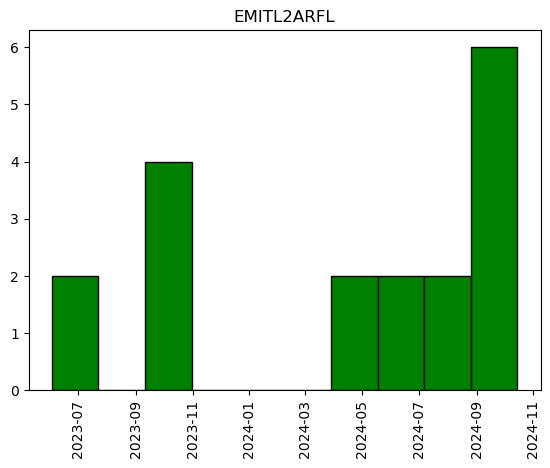

In [32]:
emit_gdf.hist(column='datetime_obj', by='shortname', bins=10, color='green', edgecolor='black', linewidth=1, sharey=True);

### 3.3 Visualizing Intersecting Coverage - NEON and EMIT

Now that we have geodataframes containing some co-located data, we can visualize them on a map using `folium`.

In [33]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox,
                name='bounding_box',).add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="Niwot Ridge ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

### 3.4 Previewing EMIT Browse Imagery
The EMIT browse imagery is not orthorectified, so to get an idea what scenes look like, we can plot them in a grid using matplotlib.

> Note: Black space indicates onboard cloud masking that occurs before data is downlinked from the ISS.

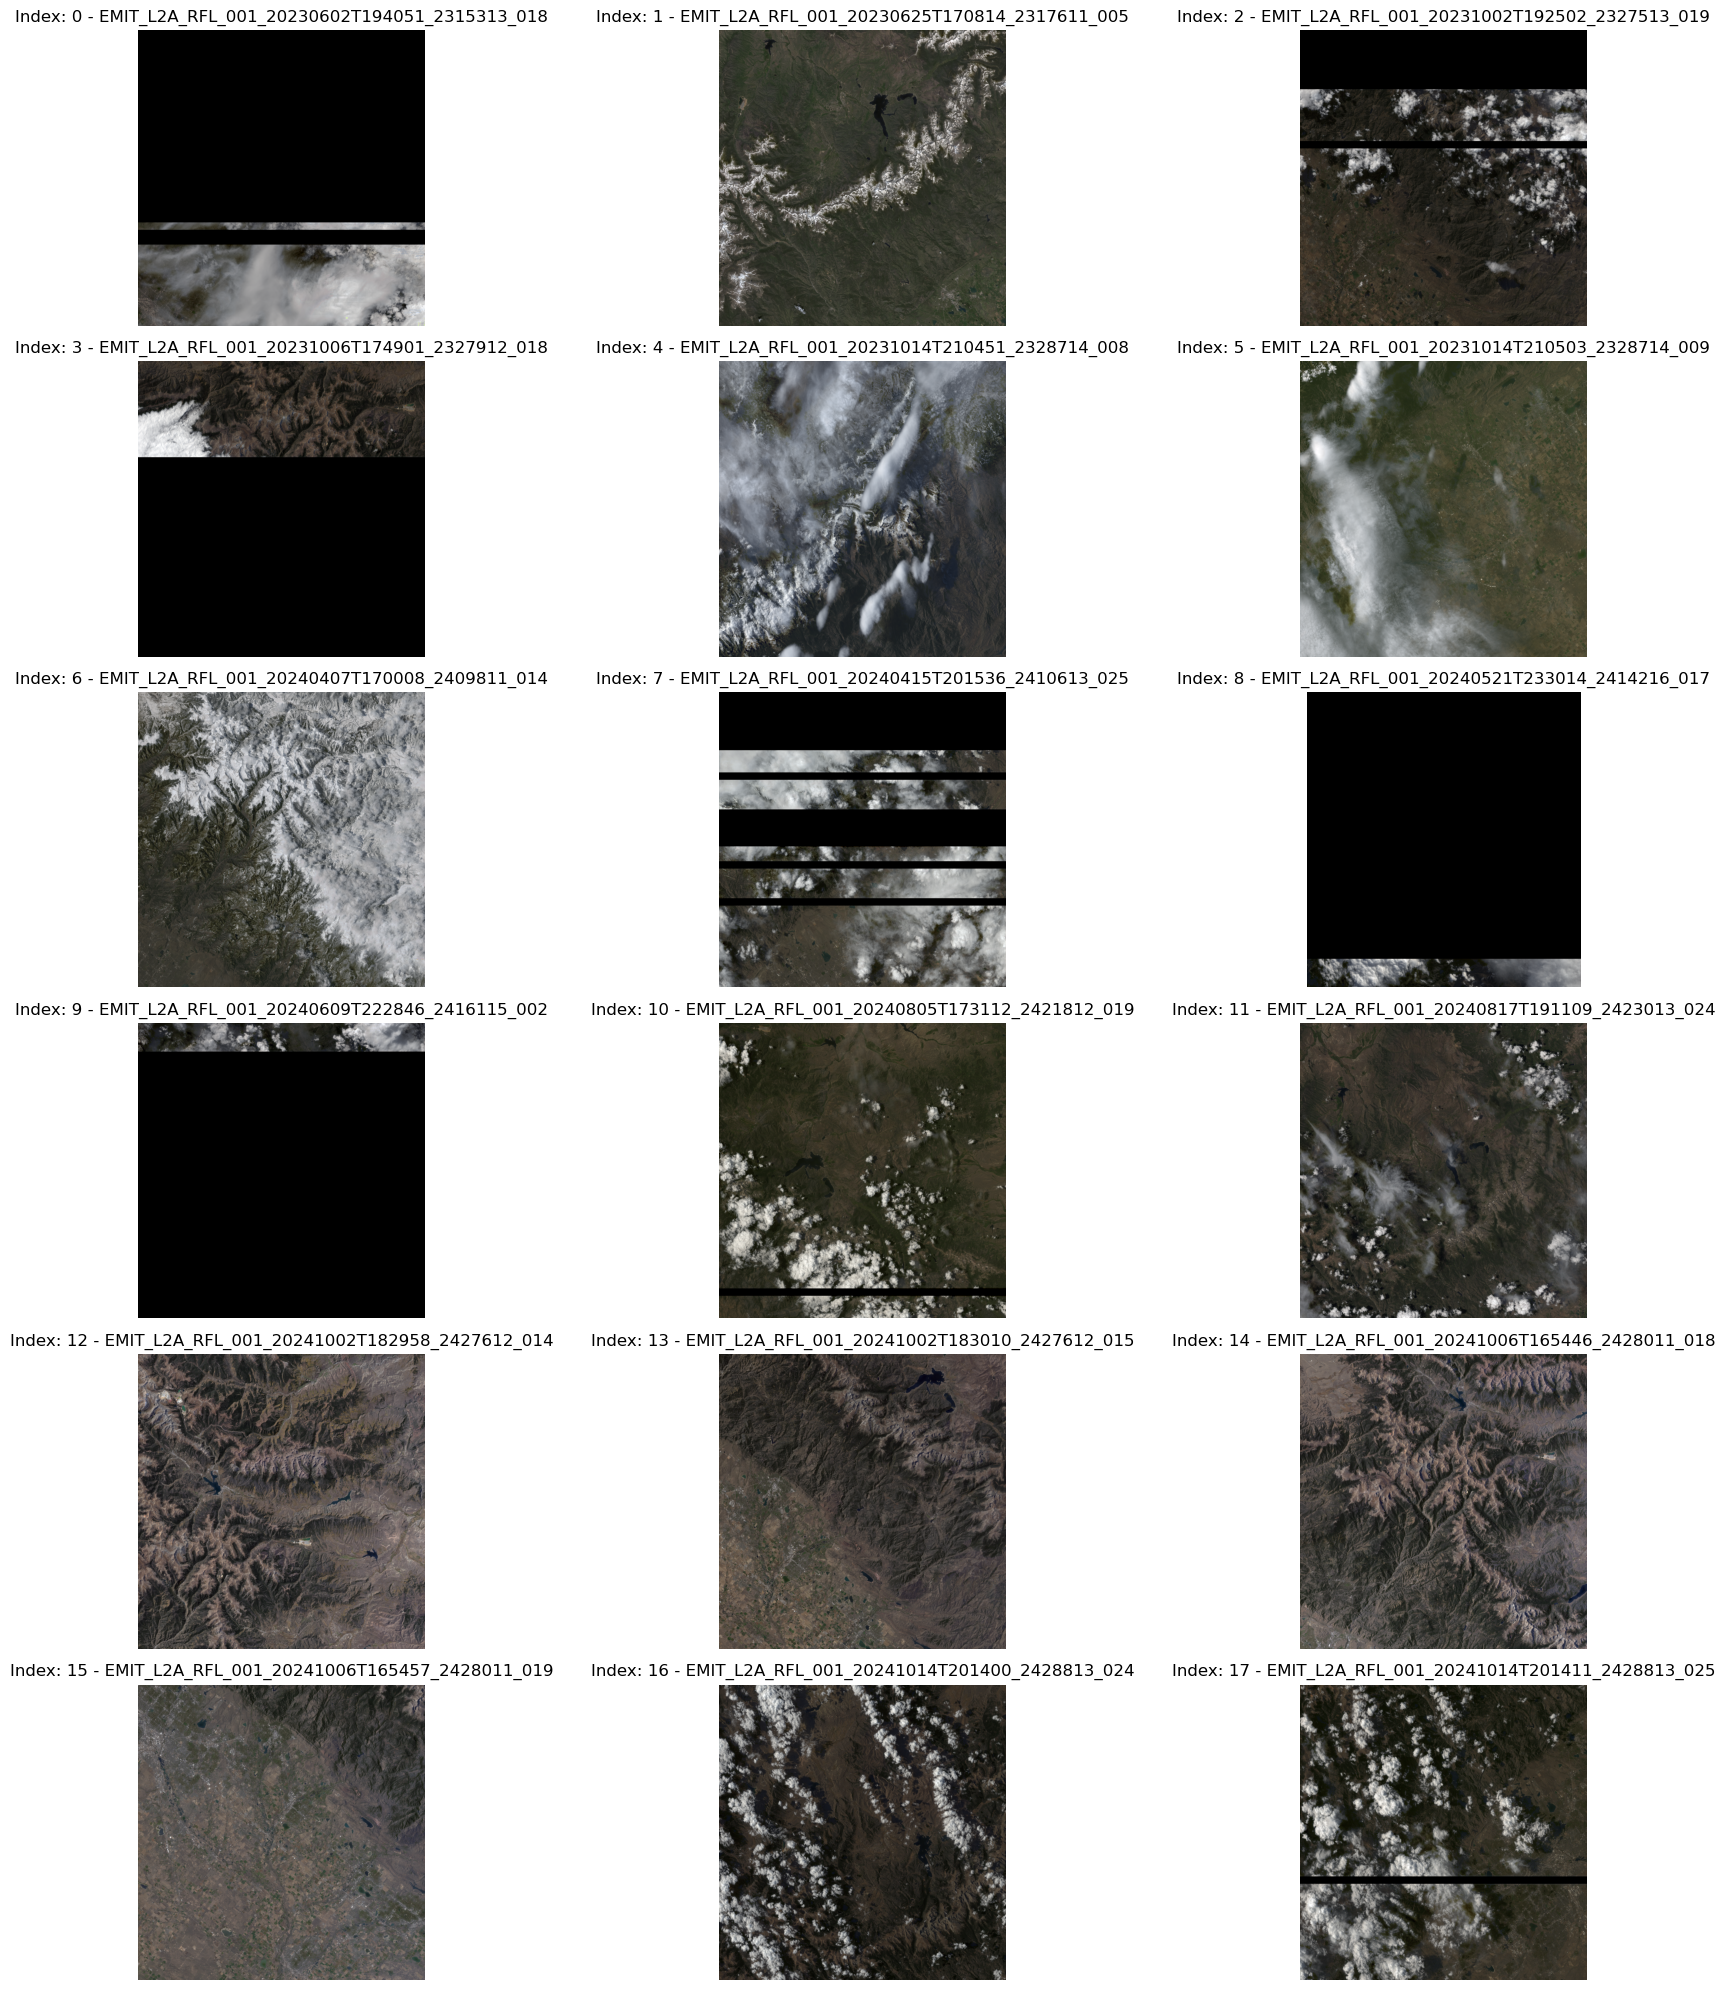

In [34]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

### 3.5 Further Filtering - Cloud Conditions

We can see that some of these granules likely won't work because of the large amount of cloud cover, we can use a list of these to filter them out. Make a list of indexes to filter out. Filter out the cloudy granules.

In [35]:
# set a threshold for cloud cover and filter to remove scenes with >30% cloud cover
emit_gdf_clear = emit_gdf[emit_gdf.cloud_cover < 30]

In [36]:
emit_gdf_clear

concept_id                                       granule  \
1   G2736967625-LPCLOUD  EMIT_L2A_RFL_001_20230625T170814_2317611_005   
12  G3257346139-LPCLOUD  EMIT_L2A_RFL_001_20241002T182958_2427612_014   
13  G3257347461-LPCLOUD  EMIT_L2A_RFL_001_20241002T183010_2427612_015   
14  G3262384699-LPCLOUD  EMIT_L2A_RFL_001_20241006T165446_2428011_018   

          start_datetime          end_datetime  cloud_cover day_night  \
1   2023-06-25T17:08:14Z  2023-06-25T17:08:26Z            8       Day   
12  2024-10-02T18:29:58Z  2024-10-02T18:30:10Z            3       Day   
13  2024-10-02T18:30:10Z  2024-10-02T18:30:22Z           13       Day   
14  2024-10-06T16:54:46Z  2024-10-06T16:54:57Z            6       Day   

                                             geometry  \
1   POLYGON ((-105.92612 40.60380, -106.33020 39.9...   
12  POLYGON ((-105.88072 40.38627, -106.82918 39.8...   
13  POLYGON ((-105.11633 40.83775, -106.07584 40.2...   
14  POLYGON ((-105.49657 40.35713, -106.44131 39.7...   

                                               browse   shortname  \
1   https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
12  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
13  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
14  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   

                datetime_obj  
1  2023-06-25 17:08:14+00:00  
12 2024-10-02 18:29:58+00:00  
13 2024-10-02 18:30:10+00:00  
14 2024-10-06 16:54:46+00:00

We can see that there are a few scenes with < 30% cloud cover. One is captured in late June (June 25) 2023, which is close in time to when NEON typically surveys Niwot Ridge. NEON surveys during "peak-greenness", when leaves are most photosynthetically active, which at NIWO usually occurs in July - August (in 2023 NIWO was surveyed on July 24, Aug 15 and Aug 21).

Let's take a look at the June 2023 clear-weather EMIT dataset (Index 1):

- **1**: `EMIT_L2A_RFL_001_20230625T170814_2317611_005`

We can plot this scene as follows:

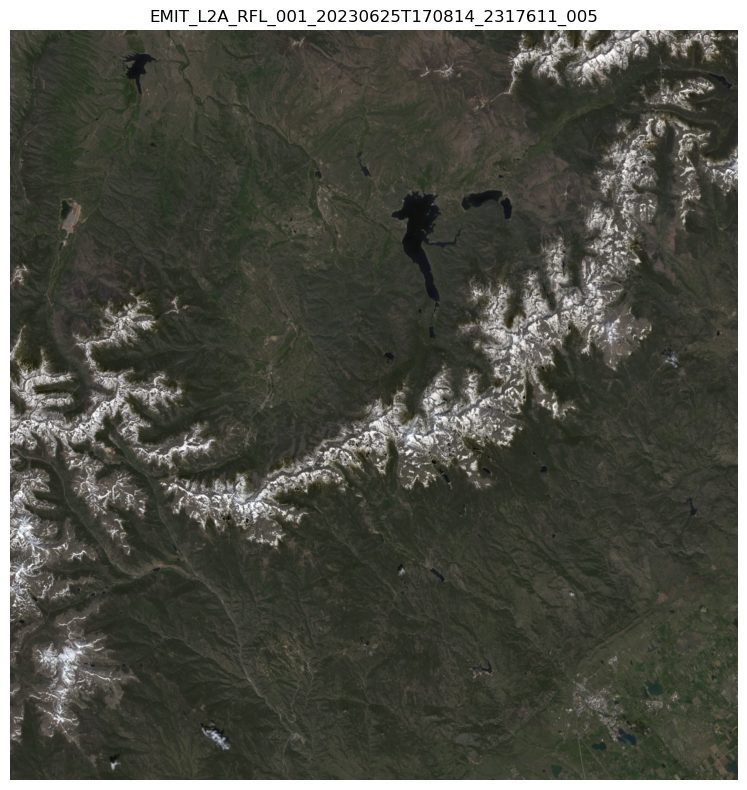

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
img = io.imread(emit_gdf_clear['browse'][1])
ax.imshow(img)
ax.set_title(f"{emit_gdf_clear['granule'][1]}")
ax.axis('off')
plt.tight_layout()
plt.show()

**We can now go back to our `folium` plot above and  re-run the cell to update it based on our filtering.**

In [38]:
# Plot Using Folium
# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add NIWO Bounding Box
folium.GeoJson(niwo_bbox,
                name='bounding_box',
                ).add_to(map1)

# Add roi geodataframe
niwo_polygon.explore("flightbxID",
                      popup=True,
                      categorical=True,
                      cmap='Set3',
                      style_kwds=dict(opacity=0.7, fillOpacity=0.4),
                      name="Niwot Ridge ROI",
                      m=map1)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf_clear.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(emit_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

## 3.6 Generating a list of EMIT URLs and downloading data

Creating a list of results URLs will include all of these assets, so if we only want a subset we need an additional filter to keep the specific assets we want. If you look back, you can see we kept the same indexing throughout the notebook. This enables us to simply subset the `earthaccess` results object to retrieve the results we want. 

Create a list of index values to keep.

In [40]:
keep_granules = [1]

Filter the results list.

In [41]:
filtered_results = [result for i, result in enumerate(emit_query_results) if i in keep_granules]

Now we can download all of the associated assets, or retrieve the URLS and further filter them to specifically what we want. 

First, log into Earthdata using the `login` function from the `earthaccess` library. The `persist=True` argument will create a local `.netrc` file if it doesn't exist, or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. As mentioned in section 1.2, this step is not necessary to conduct searches, but is needed to download or stream data.

Now we can download all assets using the following cells. First you will need to log in to your earthaccess account.

In [52]:
# Log in to earthaccess
earthaccess.login()

Enter your Earthdata Login username:  bhass@battelleecology.org
Enter your Earthdata password:  ········


In [53]:
# Download All Assets for Granules in Filtered Results
earthaccess.download(filtered_results, './data/emit_refl')

 Getting 1 granules, approx download size: 3.5 GB


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

['data\\emit_refl\\EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc',
 'data\\emit_refl\\EMIT_L2A_RFLUNCERT_001_20230625T170814_2317611_005.nc',
 'data\\emit_refl\\EMIT_L2A_MASK_001_20230625T170814_2317611_005.nc']

Congratulations! You have now downloaded co-located hyperspectral reflectance data from NEON airborne collections and the EMIT instrument on the ISS.

## Contact Info:  

**Land Processes Distributed Active Archive Center (LP DAAC)**<sup>1</sup>

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Website: <https://lpdaac.usgs.gov/>  

<sup>1</sup>Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 

**National Ecological Observatory Network (NEON)**<sup>2</sup>

Website: <https://www.neonscience.org/>   
Contact: <https://www.neonscience.org/about/contact-us>   
Date last modified: 10-31-2025

<sup>2</sup>NEON is a project sponsored by the National Science Foundation and operated by Battelle.